# Alice and Bob optimize their bike paint shop with pyschedule

Alice and Bob are running a paint shop for bikes where they pimp bikes with fresh colors. Today they have to paint a green and a red bike. To get started they import pyschedule and create a new scenario. We use hours as granularity and expect a working day of at most 10 hours, so we set the planning horizon to 10. Some solvers do not need this parameter, but the default solver requires it:

In [1]:
from pyschedule import Scenario, solvers, plotters
S = Scenario('bike_paint_shop', horizon=10)

Then they create themselves as resources:

In [2]:
Alice = S.Resource('Alice')
Bob = S.Resource('Bob')

Painting a bike takes two hours. Moreover, after the bike has been painted, it needs to get post-processed (e.g. tires pumped) which takes one hour (which is the default). This translates into four tasks in total:

In [3]:
green_paint, red_paint = S.Task('green_paint', length=2), S.Task('red_paint', length=2)
green_post, red_post = S.Task('green_post'), S.Task('red_post')

Clearly, one can only do the post-processing after the painting with an arbitrary gap in between. For the red paint we are a little stricter, here we want to start the post-processing exactly one hour after the painting since this is the time the color takes to dry:

In [4]:
S += green_paint < green_post, red_paint + 1 <= red_post

Each task can be done by either Alice or Bob:

In [5]:
green_paint += Alice|Bob
green_post += Alice|Bob

red_paint += Alice|Bob
red_post += Alice|Bob

So lets have a look at the scenario:

In [6]:
S.clear_solution()
print(S)

###############################################

SCENARIO: bike_paint_shop / horizon: 10

OBJECTIVE: None

RESOURCES:
Alice
Bob

TASKS:
green_paint : Alice|Bob
red_paint : Alice|Bob
green_post : Alice|Bob
red_post : Alice|Bob

JOINT RESOURCES:
Alice|Bob : green_post
Alice|Bob : red_post
Alice|Bob : red_paint
Alice|Bob : green_paint

LAX PRECEDENCES:
green_paint < green_post

TIGHT PRECEDENCES:
red_paint + 1 <= red_post

###############################################


We havent defined an objective yet. We want to finish all tasks as early as possible, and so we use the MakeSpan and check the scenario again:

In [7]:
S.use_makespan_objective()
print(S)

###############################################

SCENARIO: bike_paint_shop / horizon: 10

OBJECTIVE: MakeSpan

RESOURCES:
Alice
Bob

TASKS:
green_paint : Alice|Bob
red_paint : Alice|Bob
green_post : Alice|Bob
red_post : Alice|Bob
MakeSpan : Alice

JOINT RESOURCES:
Alice|Bob : green_post
Alice|Bob : red_post
Alice|Bob : red_paint
Alice|Bob : green_paint

LAX PRECEDENCES:
green_paint < green_post
green_paint < MakeSpan
red_paint < MakeSpan
green_post < MakeSpan
red_post < MakeSpan

TIGHT PRECEDENCES:
red_paint + 1 <= red_post

###############################################


Hence, we want to minimize the position of the MakeSpan task subject to the constraint that it is scheduled after all other tasks. Thus, the position of the MakeSpan is the length of our schedule. Now we have the first version of our scenario, lets solve and plot it:

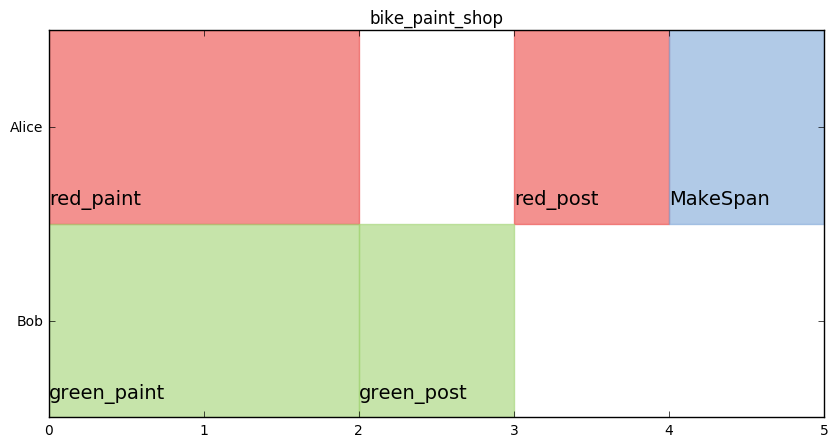

In [8]:
# Set some colors for the tasks
task_colors = { green_paint   : '#A1D372',
                green_post    : '#A1D372', 
                red_paint     : '#EB4845',
                red_post      : '#EB4845',
                S['MakeSpan'] : '#7EA7D8'}

# A small helper method to solve and plot a scenario
def run(S) :
    if solvers.mip.solve(S):
        %matplotlib inline
        plotters.matplotlib.plot(S,task_colors=task_colors,fig_size=(10,5))
    else:
        print('no solution exists')
run(S)

Note that it could happen that somebody needs to paints the red bike and then do the green post-processing. This would be annoying, switching bikes takes too much time. We use the following constraints to ensure that the green/red painting and post-processing is always done by the same persons:

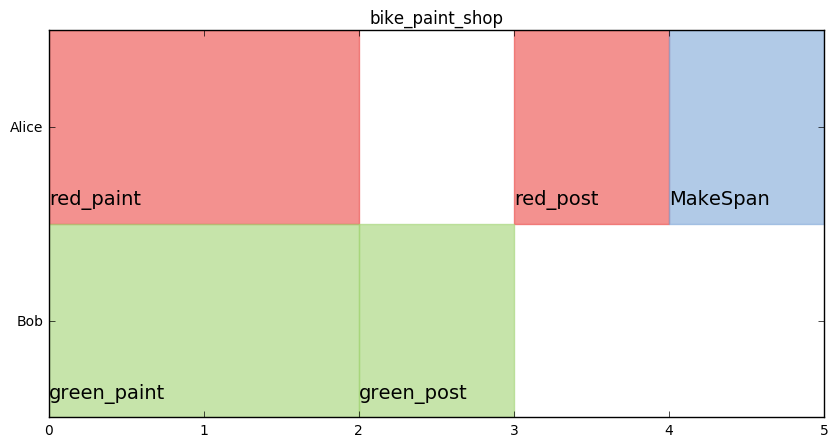

In [9]:
# First remove the old resource to task assignments
green_paint -= Alice|Bob
green_post -= Alice|Bob
red_paint -= Alice|Bob
red_post -= Alice|Bob

# Add new shared ones
green_resource = Alice|Bob
green_paint += green_resource
green_post += green_resource

red_resource = Alice|Bob
red_paint += red_resource
red_post += red_resource
run(S)

This schedule completes after four hours and suggests to paint both bikes at the same time. However, Alice and Bob have only a single paint shop which they need to share:

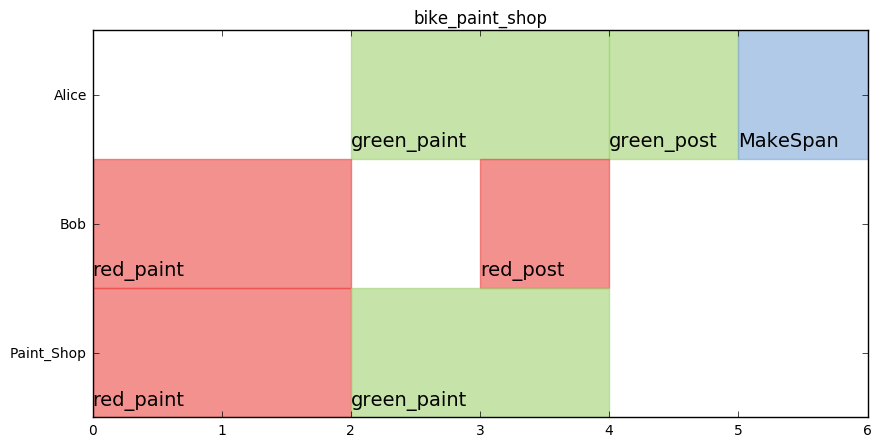

In [10]:
Paint_Shop = S.Resource('Paint_Shop')
red_paint += Paint_Shop
green_paint += Paint_Shop
run(S)

Great, everybody can still go home after five hours and have a late lunch! Unfortunately, Alice receives a call that the red bike will only arrive after two hours:

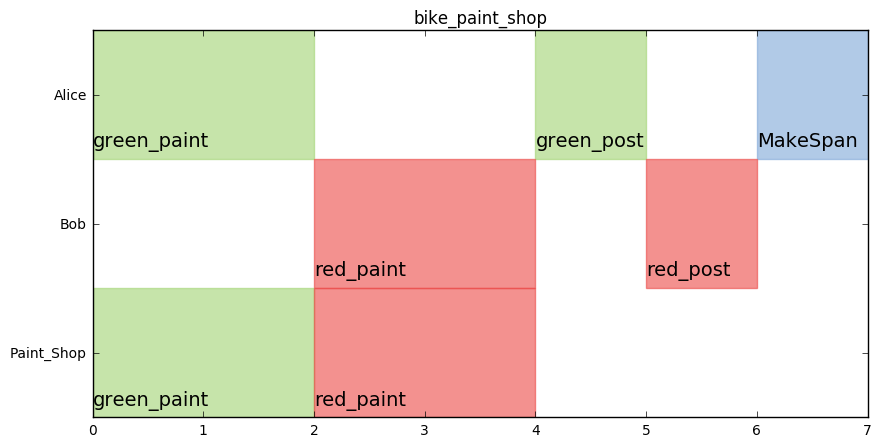

In [11]:
S += red_paint > 2
run(S)

Too bad, everything takes now size hours to finish. Therefore Alica and Bob decide to schedule a lunch after the third hour and before the fifth hour:

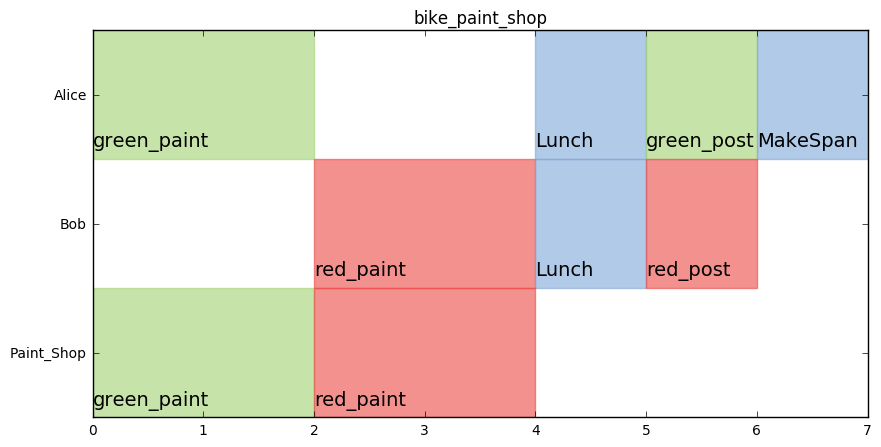

In [12]:
Lunch = S.Task('Lunch')
Lunch += {Alice, Bob}
S += Lunch > 3, Lunch < 5
task_colors[Lunch] = '#7EA7D8'
run(S)

Alice is a morning person and  wants to finish three hours of work before lunch, that is, before the third hour:

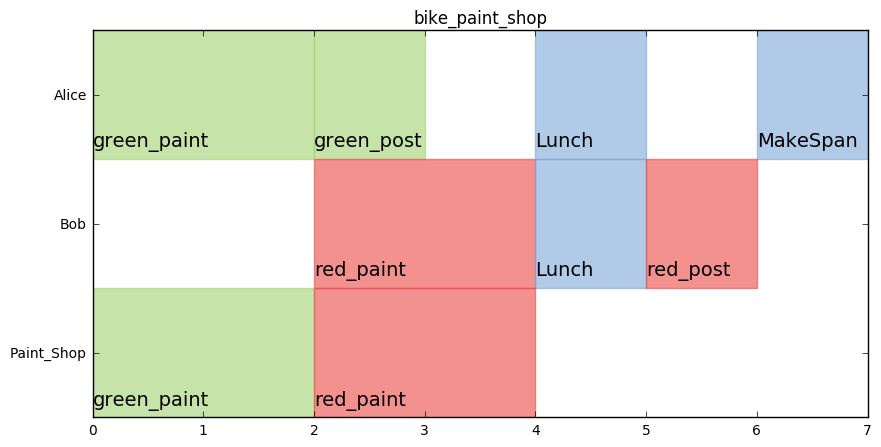

In [13]:
S += Alice['length'][:3] >= 3
run(S)

The weather forecast is really good for the afternoon, so Alice and Bob decide to close the shop after lunch, that is, they fix the horizon to 5 hours. Unfortunately, the following happens:

In [14]:
S.horizon = 5
run(S)

no solution exists


This happens because there is not enough time to finish all task. Therefore, they need to priorize: Lets say the green bike gives a reward of 100 when finished while the red one only 50:

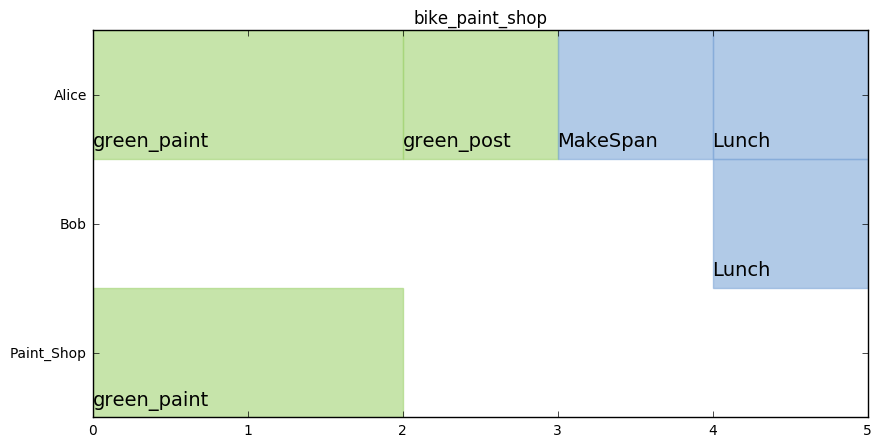

In [15]:
green_post.reward = 100
green_paint.reward = 0 #we need to make the paint steps optional by setting the reward to 0
red_post.reward = 50
red_paint.reward = 0
run(S)

Observe that the situation that the painting of the red and green bike is absolutely similar. Knowing this can speed up the computation quite a bit. Some scheduling problems can only be solved with this additional information. We can pass this information to the solver by setting a ```group```-parameter for the involved tasks. First we remove the added rewards in the last step and set the horizon back to 10:

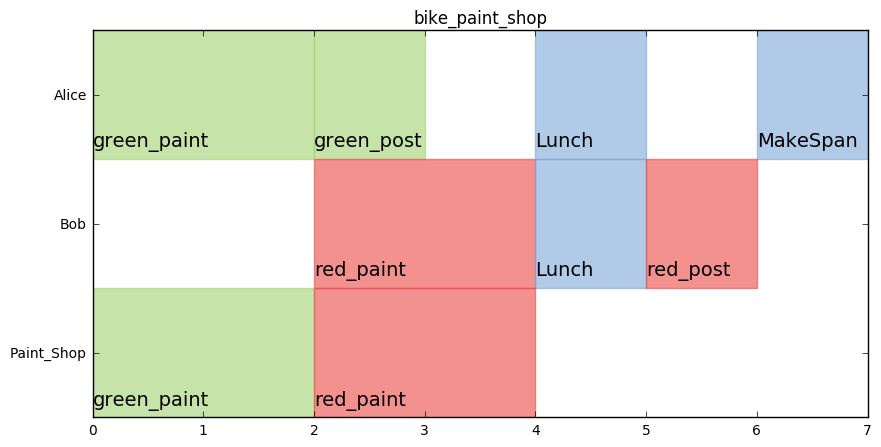

In [16]:
S.horizon = 10
green_post.reward = None
green_paint.reward = None
red_post.reward = None
red_paint.reward = None

green_paint.group = 'paint'
red_paint.group = 'paint'
green_post.group = 'post'
red_post.group = 'post'
run(S)

All this sounds quite trivial, but think about the same problem with many bikes and many persons!